In [1]:
from typing import List
from data_service import get_sales_depart_billboard,get_index_daily
from scr.plotting import plot_indicator,plot_quantile_group_ret
import pandas as pd
import numpy as np
import empyrical as ep
import matplotlib.pyplot as plt
import seaborn as sns
from scr.tushare_api import TuShare
from scr import HMA,get_forward_returns

my_ts = TuShare()

# 数据准备

In [3]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2021-12-31')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

机构龙虎榜数据获取:   0%|          | 0/2188 [00:00<?, ?it/s]

In [2]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [3]:
# 获取沪深300数据
hs300:pd.DataFrame = get_index_daily(code='000300.SH',start_date = '20130101',end_date='20211231')

# 特征构建

In [4]:
# 计算当日所有单个席位净流入金额(单个席位买入 金额-单个席位卖出金额)的总和
nextbuy: pd.Series = billboard_df.groupby('trade_date')['net_buy'].sum()

# IS_NetBuy/沪深 300 指数当日成交金额
is_netbuy_s: pd.Series = nextbuy / (hs300['amount'] * 1000)
is_netbuy_s: pd.Series = is_netbuy_s.dropna()

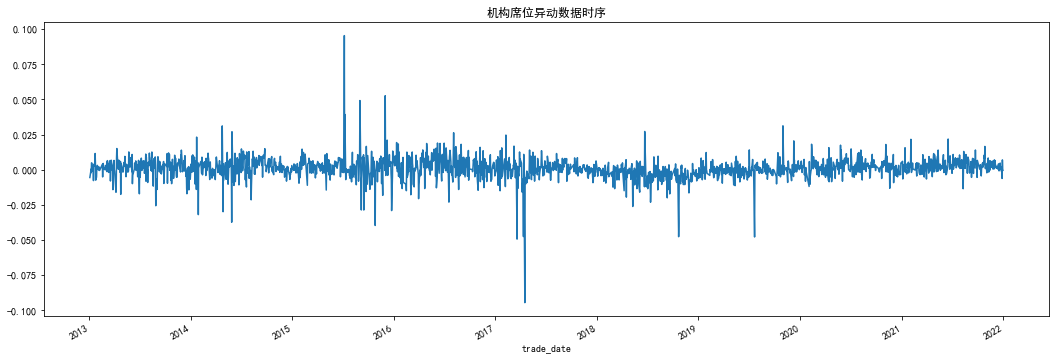

In [5]:
is_netbuy_s.plot(figsize=(18,6),title='机构席位异动数据时序');

In [59]:
forward_returns: pd.Series = get_forward_returns(hs300['close'],
                                                 [3, 5, 10, 15, 20, 60])

In [60]:
group = pd.qcut(is_netbuy_s,50,labels=False) + 1
group_ret = forward_returns.groupby(group)['10日收益'].mean()

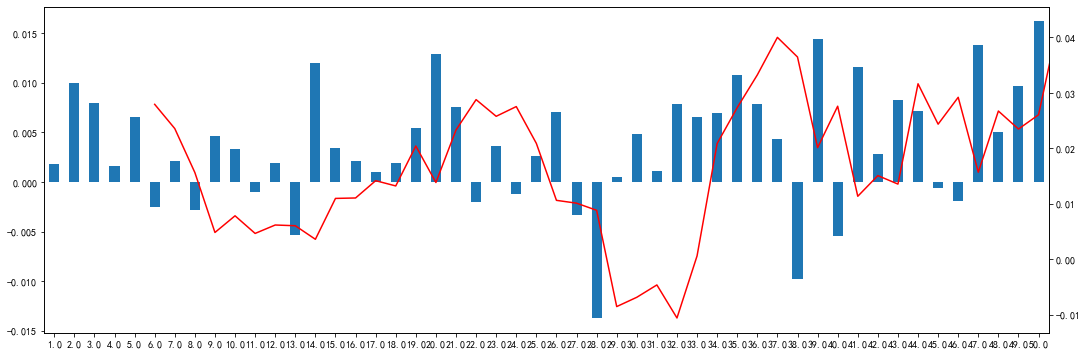

In [61]:
ax = group_ret.plot(kind='bar',figsize=(18,6))
group_ret.rolling(5).sum().plot(kind='line',color='red',secondary_y=True);

# 信号构建

In [8]:
# 计算HMA信号
is_netbuy_s_s:pd.Series = HMA(is_netbuy_s,30).dropna()
is_netbuy_s_l:pd.Series = HMA(is_netbuy_s,100).dropna()

In [9]:
# 数据对齐
netbuy_s_s,netbuy_s_l = is_netbuy_s_l.align(is_netbuy_s_s,join='left',axis=0)

In [10]:
indincator:pd.DataFrame = pd.concat((netbuy_s_s,netbuy_s_l),axis=1)
indincator.columns = ['fast','slow']

GridSpec(3, 1)

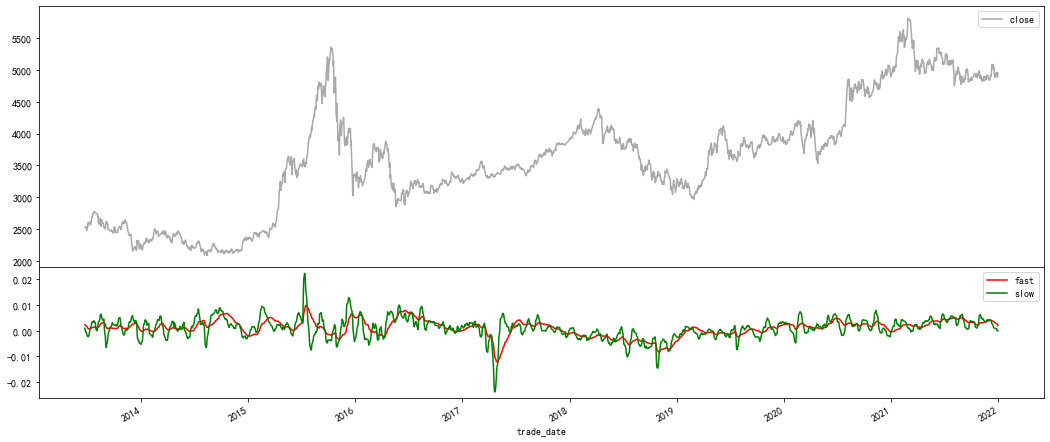

In [11]:
plot_indicator(hs300['close'],indincator)

In [12]:
buy1 = (netbuy_s_s > netbuy_s_l) & (netbuy_s_s > 0) & (netbuy_s_l > 0)
buy2 = (netbuy_s_s < netbuy_s_l) & (netbuy_s_s < 0) & (netbuy_s_l < 0)

buy = buy1|buy2

sell1 = (netbuy_s_s > netbuy_s_l) & (netbuy_s_s > 0) & (netbuy_s_l < 0)
sell2 = (netbuy_s_s < netbuy_s_l) & (netbuy_s_s < 0) & (netbuy_s_l > 0)

sell = sell1 | sell2

In [13]:
hold = pd.Series(index=sell.index)
previous = 0
i = 0
for b,s in zip(buy,sell):
    
    if b:
        
        hold.iloc[i] = 1
        previous = 1
    elif s:
        
        hold.iloc[i] = 0
        previous = 0
    else:    
        
        hold.iloc[i] = previous
        
    i+=1

<ipython-input-13-3cd5c261565a>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hold = pd.Series(index=sell.index)


<AxesSubplot:xlabel='trade_date'>

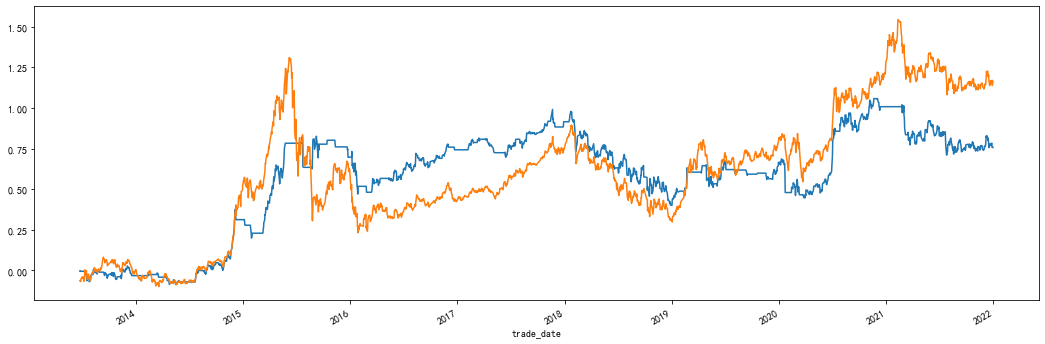

In [21]:
pct_ser = hs300['close'].pct_change()
next_ser = pct_ser.shift(-1)

pct_ser = pct_ser.reindex(buy.index)
next_ser = next_ser.reindex(buy.index)

ep.cum_returns(next_ser*hold).plot(figsize=(18,6))
ep.cum_returns(pct_ser).plot()

# 回测

In [15]:
from scr.bt_func import (ma_cross,get_backtesting,analysis_rets,analysis_trade)

In [16]:
bt_data:pd.DataFrame = hs300[['close','open','high','low','vol']].copy()
bt_data.rename(columns={'vol':'volume'},inplace=True)
bt_data['openinterest'] = 0
bt_data = pd.concat((bt_data,indincator),axis=1).dropna()

In [17]:
bt_data.head()

,close,open,high,low,volume,openinterest,fast,slow
trade_date,,,,,,,,
2013-06-24,2171.210,2308.069,2308.069,2164.325,86597259.0,0,0.002327,0.000898
2013-06-25,2165.421,2146.053,2169.211,2023.171,107554882.0,0,0.002241,0.000353
2013-06-26,2168.297,2170.326,2181.021,2131.860,79256426.0,0,0.002158,0.000007
2013-06-27,2160.735,2172.848,2200.213,2153.175,75406753.0,0,0.002012,-0.000501
2013-06-28,2200.639,2149.030,2227.461,2139.372,79451327.0,0,0.001925,-0.000457


In [18]:
bt_result = get_backtesting(bt_data,'hs300',ma_cross)

2013-06-25,BUY EXECUTED,ref:1,Price:2146.2676,Size:41.00,Cost:87996.9718,Comm 0.0000,Stock:hs300
2013-06-26,SELL EXECUTED,ref:2,Price:2170.1090,Size:-41.00,Cost:87996.9718,Comm 0.0000,Stock:hs300
2013-06-27,BUY EXECUTED,ref:3,Price:2173.0653,Size:41.00,Cost:89095.6767,Comm 0.0000,Stock:hs300
2013-06-28,SELL EXECUTED,ref:4,Price:2148.8151,Size:-41.00,Cost:89095.6767,Comm 0.0000,Stock:hs300
2013-07-12,BUY EXECUTED,ref:5,Price:2319.2549,Size:38.00,Cost:88131.6863,Comm 0.0000,Stock:hs300
2013-07-15,SELL EXECUTED,ref:6,Price:2289.5330,Size:-38.00,Cost:88131.6863,Comm 0.0000,Stock:hs300
2013-08-02,BUY EXECUTED,ref:7,Price:2263.7213,Size:39.00,Cost:88285.1326,Comm 0.0000,Stock:hs300
2013-08-05,SELL EXECUTED,ref:8,Price:2249.7510,Size:-39.00,Cost:88285.1326,Comm 0.0000,Stock:hs300
2013-08-06,BUY EXECUTED,ref:9,Price:2270.8991,Size:38.00,Cost:86294.1646,Comm 0.0000,Stock:hs300
2013-08-07,SELL EXECUTED,ref:10,Price:2292.1498,Size:-38.00,Cost:86294.1646,Comm 0.0000,Stock:hs300
2013-08-30,BUY EXEC

,年化收益率,累计收益,波动率,夏普,最大回撤,索提诺比率,Calmar
策略,-3.88%,-27.87%,8.23%,-43.99%,-38.17%,-60.13%,-10.18%
基准,10.48%,127.54%,22.88%,55.12%,-46.70%,75.96%,22.45%


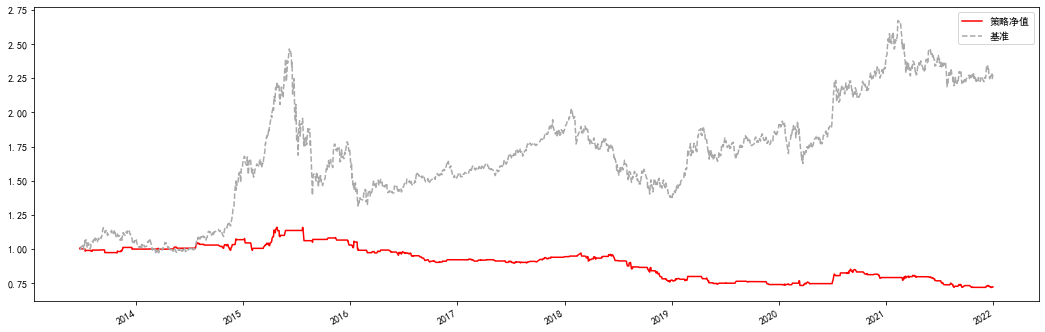

In [19]:
analysis_rets(bt_data['close'],bt_result.result)